# Introduction
The Generative Pre-Trained Transformer (GPT) 2 is an artificial intelligence developed by OpenAI in 2019 and allows for several purposes: text summarization, translation, question-answering, and text generation. GPT-2 is pre-trained on a large English data corpus, furthermore, can be fine-tuned for a specific task.

Here, I will use the Huggingface Distilled-GPT2 (`DistilGPT2`) model. `DistilGPT2` has 82 million parameters and was developed by knowledge distillation, moreover is lighter and faster than GPT-2 (124.2M).

# Dataset

ArXiv Papers dataset: https://huggingface.co/datasets/CShorten/ML-ArXiv-Papers

In [1]:
from datasets import load_dataset

data = load_dataset('CShorten/ML-ArXiv-Papers')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/CShorten--ML-ArXiv-Papers-be2c6ddb53143cb6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'title', 'abstract'],
        num_rows: 117592
    })
})

In [3]:
# inspect dataset
df = data['train'].to_pandas()
df

,Unnamed: 0,Unnamed: 0.1,title,abstract
0,0,0.0,Learning from compressed observations,The problem of statistical learning is to co...
1,1,1.0,Sensor Networks with Random Links: Topology De...,"In a sensor network, in practice, the commun..."
2,2,2.0,The on-line shortest path problem under partia...,The on-line shortest path problem is conside...
3,3,3.0,A neural network approach to ordinal regression,Ordinal regression is an important type of l...
4,4,4.0,Parametric Learning and Monte Carlo Optimization,This paper uncovers and explores the close r...
...,...,...,...,...
117587,4995,NaN,Detecting COVID-19 Conspiracy Theories with Tr...,The sharing of fake news and conspiracy theori...
117588,4996,NaN,Fair Feature Subset Selection using Multiobjec...,The feature subset selection problem aims at s...
117589,4997,NaN,A Simple Duality Proof for Wasserstein Distrib...,We present a short and elementary proof of the...
117590,4998,NaN,Combined Learning of Neural Network Weights fo...,"We introduce CoLN, Combined Learning of Neural..."


Median 1141.0
Mean 1157.3933090686442


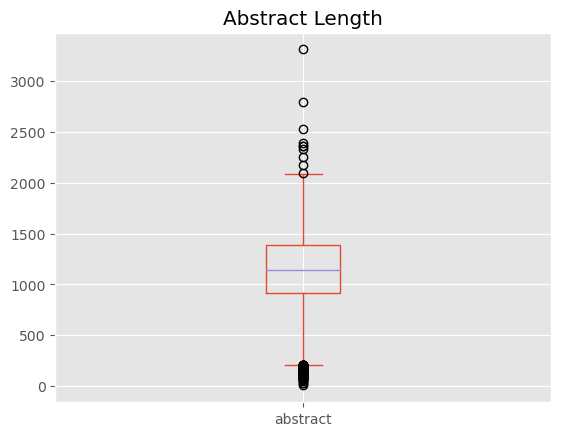

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

print('Median', df['abstract'].apply(len).median())
print('Mean', df['abstract'].apply(len).mean())
df['abstract'].apply(len).plot(kind='box', title='Abstract Length');

Median 164.0
Mean 166.95294747942037
Mode 150


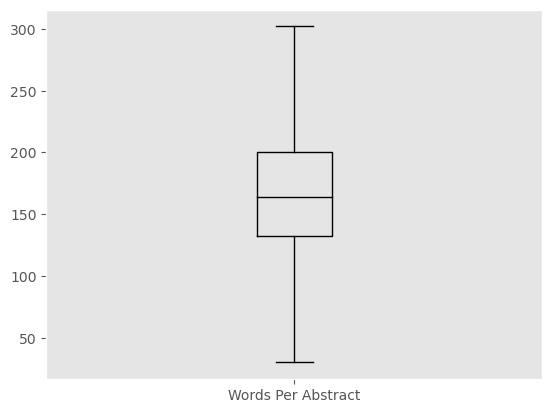

In [5]:
df["Words Per Abstract"] = df["abstract"].str.split().apply(len)
print('Median', df['Words Per Abstract'].median())
print('Mean', df['Words Per Abstract'].mean())
print('Mode', df['Words Per Abstract'].mode()[0])
df.boxplot("Words Per Abstract", grid=False, showfliers=False, color="black");

In [6]:
# split into Train and Validation Set
data = data['train'].train_test_split(shuffle=True, seed=10, test_size=0.2)

In [7]:
# assert split
len(data['train']), len(data['test'])

(94073, 23519)

# Tokenizer

In [8]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [9]:
from transformers import AutoTokenizer

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

- `return_overflowing_tokens`: tokenize the whole input and split it into several chunks, used to map the examples that have been split into multiple parts due to their length after tokenization back to their original example
- `return_length`: return the length of each created chunk automatically

In [10]:
from pprint import pprint
context_length = 164  # median

outputs = tokenizer(data['train']['abstract'][:2], 
                    truncation=True,
                    max_length=context_length, 
                    return_overflowing_tokens=True,
                    return_length=True)

print(outputs)

{'input_ids': [[220, 20414, 1233, 40903, 10229, 284, 262, 1429, 286, 3047, 257, 16001, 3710, 198, 27349, 284, 4620, 1365, 9922, 416, 4673, 422, 257, 1029, 5339, 4701, 198, 27349, 13, 4042, 286, 262, 4683, 3725, 1233, 40903, 5050, 1277, 262, 3710, 198, 1462, 1061, 262, 4701, 416, 12336, 262, 4701, 338, 5072, 11, 3895, 8739, 393, 511, 198, 17080, 3890, 13, 554, 428, 670, 11, 356, 18077, 257, 5337, 835, 284, 4620, 428, 3061, 25, 416, 198, 17080, 4509, 262, 3725, 832, 257, 5554, 1143, 2272, 13, 4784, 284, 674, 2446, 11, 198, 1169, 4701, 338, 3895, 8739, 389, 5554, 1143, 284, 2380, 262, 1388, 5874, 10838, 198, 268, 5589, 21390, 287, 262, 3895, 8739, 13, 383, 3710, 318, 788, 1965, 284, 4331, 262, 198, 40972, 1143, 10552, 11, 543, 4145, 5107, 262, 4876, 326, 262, 3710, 3544, 284, 198, 35720, 422, 262, 4701, 13, 7945, 663, 21654, 11, 356, 905, 326, 674, 3164, 318, 198, 540, 284, 7800, 2482, 326, 2987, 262, 1181, 286], [262, 1242, 319, 3725, 198, 17080, 40903, 13, 1675, 326, 886, 11, 356, 2148,

In [11]:
print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 4
Input chunk lengths: [164, 30, 164, 88]
Chunk mapping: [0, 0, 1, 1]


We can see that we get 4 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 164 tokens (30 and 88, respectively). These represent just a small fraction of the total chunks that we have, so we can safely throw them away.

With the `overflow_to_sample_mapping` field, we can also reconstruct which chunks belonged to which input samples.

In [12]:
def tokenization(dataset):
    outputs = tokenizer(dataset['abstract'], 
                        truncation=True,
                        max_length=context_length, 
                        return_overflowing_tokens=True,
                        return_length=True)
    input_batch = []
    for length, input_ids in zip(outputs['length'], outputs['input_ids']):
        if length == context_length:
            input_batch.append(input_ids) # drop remains
    return {'input_ids': input_batch}
    
    
tokenized_data = data.map(tokenization, batched=True, remove_columns=data['train'].column_names)
tokenized_data

  0%|          | 0/95 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 93693
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 23478
    })
})

# Padding with Data Collators

Note that `DataCollatorForLanguageModeling` supports both masked language modeling (MLM) and causal language modeling (CLM). 

By default it prepares data for MLM, but we can switch to CLM by setting the argument `mlm=False`:

In [13]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token # add padding token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [14]:
out = data_collator([tokenized_data["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 164])
attention_mask shape: torch.Size([5, 164])
labels shape: torch.Size([5, 164])


# Fine Tune DistilGPT2

In [15]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_name,
                                    vocab_size=len(tokenizer),
                                    n_ctx=context_length,
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    )

In [16]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name)

In [17]:
model_size = sum(t.numel() for t in model.parameters())
print(f"DistilGPT-2 size: {model_size/1000**2:.1f}M parameters")

DistilGPT-2 size: 81.9M parameters


In [18]:
from transformers import Trainer, TrainingArguments

batch_size = 32

args = TrainingArguments(
    output_dir="arxiv-papers-ds",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    weight_decay=0.1,
    warmup_steps=200,
    lr_scheduler_type="cosine",
    optim='adamw_torch',
    learning_rate=3e-5,
    save_steps=500,
    fp16=True,  
    push_to_hub=False,
    report_to='none',
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.426928
2,3.717400,3.330056
3,3.445200,3.315263


TrainOutput(global_step=1098, training_loss=3.5674221407086035, metrics={'train_runtime': 4424.7086, 'train_samples_per_second': 63.525, 'train_steps_per_second': 0.248, 'total_flos': 1.1762680483381248e+16, 'train_loss': 3.5674221407086035, 'epoch': 3.0})

In [19]:
evaluation = trainer.evaluate()
evaluation

{'eval_loss': 3.315263271331787,
 'eval_runtime': 116.0357,
 'eval_samples_per_second': 202.334,
 'eval_steps_per_second': 6.326,
 'epoch': 3.0}

# Preplexity

It measures how well a probability distribution or probability model predicts a sample.

Perplexity is used to evaluate language models by measuring how well they predict a held-out test set. A lower perplexity score indicates that the model is better at predicting the test data.

In [20]:
import math

print(f"Perplexity: {math.exp(evaluation['eval_loss']):.2f}")

Perplexity: 27.53


# Generating Dialogue Summaries

- `num_beams`: keeps track of the top-b most probable next tokens
- `do_sample`: randomly sample from the probability distribution of the model’s outputs over the full vocabulary at each timestep. (Temprature)
-  `top_k`: restrict the number of possible tokens we can sample from at each timestep. alternatives or extensions to using temperature.
- `top_p`: An alternative is to use a dynamic cutoff.


Setting `top_k=50` and `top_p=0.9` corresponds to the rule of choosing tokens with a probability mass of 90%, from a pool of at most 50 tokens.

In [22]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_txt = "Neural Networks"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [23]:
input_ids

tensor([[ 8199,  1523, 27862]], device='cuda:0')

In [31]:
gen_kwargs = {"do_sample": True, "num_beams":8, "max_length": 256, 'top_k':50, 'top_p':0.9}
output_topk = model.generate(input_ids, **gen_kwargs, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(output_topk[0]))

Regression is a popular technique in deep neural networks (DNNs).
However, it is not well understood why DNNs are vulnerable. In this paper, we
propose a deep neural network (DNN) based on deep convolutional neural
networks (CNNs) based on deep convolutional neural networks (DNNs). We
propose a deep neural network (DNN) based on deep convolutional neural
networks (DNNs) based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
propose a DNN based on deep convolutional neural networks (DNNs). We
pro


In [29]:
input_txt = "Clustering"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_topk = model.generate(input_ids, **gen_kwargs)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Clustering is a powerful technique for deep neural networks (DNNs) to learn
high-dimensional representations. However, it has been shown to be very
challenging for DNNs to learn high-dimensional representations. In this paper, we
propose a novel method to learn high-dimensional representations of
high-dimensional representations of high-dimensional representations of high-dimensional
representations of high-dimensional representations of high-dimensional representations of
high-dimensional representations of high-dimensional representations of high-dimensional
representations of high-dimensional representations of high-dimensional representations of
high-dimensional representations of


In [30]:
input_txt = "Regression"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_topk = model.generate(input_ids, **gen_kwargs)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Regression of neural networks is a fundamental problem in machine learning
applications. In this paper, we propose a novel method for training neural
networks using a deep Convolutional Neural Network (CNN) model. The CNN
model is trained using a deep convolutional neural network (CNN) model. The
CNN model is trained using a deep convolutional neural network (CNN) model. The
CNN model is trained using a deep convolutional neural network (CNN) model. The
CNN model is trained using a deep convolutional neural network (CNN) model. The
CNN model is trained using


In [36]:
from transformers import pipeline

generator = pipeline('text-generation', model='gpt2', **gen_kwargs)
sample = generator(input_txt, pad_token_id=generator.tokenizer.eos_token_id)

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1202: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"


In [38]:
print(sample[0]['generated_text'])

Regression

In this section, we will look at some of the methods that can be used to determine whether or not you are a victim of sexual assault.

How to Determine Whether or Not You Are a Victim of Sexual Assault

In order to determine whether or not you are a victim of sexual assault, you must first determine whether or not you are a victim of sexual assault. In this section, we will look at some of the methods that can be used to determine whether or not you are a victim of sexual assault. In this section, we will look at some of the methods that can be used to determine whether or not you are a victim of sexual assault.

How to Determine Whether or Not You Are a Victim of Sexual Assault

In order to determine whether or not you are a victim of sexual assault, you must first determine whether or not you are a victim of sexual assault. In this section, we will look at some of the methods that can be used to determine whether or not you are a victim of sexual assault. In this section,

# Resources

- [DistilGPT-2](https://huggingface.co/distilgpt2)
- [I Fine-Tuned GPT-2 on 110K Scientific Papers. Here’s The Result](https://pub.towardsai.net/i-fine-tuned-gpt-2-on-110k-scientific-papers-heres-the-result-9933fe7c3c26)
- [Natural Language Processing with Transformers](https://transformersbook.com/)